# Libraries

In [ ]:
#!pip install torch_geometric rdkit

In [1]:
import random

from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Subset
from torch.optim import AdamW
import torch_geometric as pyg
from torch_geometric.nn.pool import global_mean_pool
from torch_geometric.data import Dataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch.nn import Linear, ReLU, Dropout
from torch_geometric.nn import Sequential, GCNConv, JumpingKnowledge
from torch_geometric.nn import global_mean_pool
from sklearn.metrics import r2_score
from rdkit import Chem
from rdkit.Chem import Draw

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = False

In [3]:
batch_size = 4096
epochs = 10
learning_rate = 3e-4
lr_warmup_steps = 500

device = "cuda"
random_state = 42

seed_everything(random_state)

# Data

In [4]:
df = pd.read_excel("19_35000.xlsx", index_col=0).reset_index(drop=True)
df

,Title,IC50,SMILES
0,CHEMBL2206459,0.000015,[H]\N=C(N)\N[C@@H](C1)[C@@H](NC(=O)C)[C@@H](C=...
1,CHEMBL3818159,0.000016,O=C(O)C1=C[C@H](N)[C@@H](NC(=O)C)[C@@H](C1)COC...
2,CHEMBL1956716,0.000033,C=CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O...
3,CHEMBL1956715,0.000032,CC(=O)N[C@H]([C@H](C1)N)[C@@H](C=C1C([O-])=O)O...
4,CHEMBL4444029,0.000041,O=C(O)c1c(O)c(=O)cc([nH]1)-c(c2C)ccc(c2)-c3noc...
...,...,...,...
36372,CHEMBL3699085,2366.790000,CC(=O)N[C@H]1CC[C@@H]([C@@H]12)[C@@H](O[Si](C)...
36373,CHEMBL109004,2372.100000,CC(=O)Nc(cc1)c(OC(=O)C)cc1C(=O)O
36374,CHEMBL2259758,2600.970000,c1cccc(c12)cccc2CNC(=O)CCCCCCO[C@]3(C(=O)O)C[C...
36375,CHEMBL109781,2793.000000,NCCCC(=O)Nc(c(cc1)NC(=O)C)cc1C(=O)O


In [45]:
shuffled_data = df.sample(frac=1, random_state=42)
shuffled_data[['SMILES', 'IC50']].iloc[:32000].to_csv('data_train.txt', sep=' ', index=False)
shuffled_data[['SMILES', 'IC50']].iloc[32000:].to_csv('data_test.txt', sep=' ', index=False)

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Assuming you have a DataFrame called 'data' with your data
# X should contain the features, y should contain the target variable
X = data.drop('target_column_name', axis=1)
y = data['target_column_name']

# Split the data into training and testing sets (default test_size is 0.25)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shapes of the resulting datasets
print("Training set - Features shape:", X_train.shape)
print("Training set - Target shape:", y_train.shape)
print("Testing set - Features shape:", X_test.shape)
print("Testing set - Target shape:", y_test.shape)


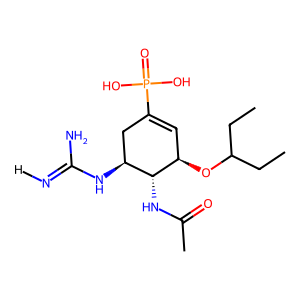

In [31]:
m = Chem.MolFromSmiles(df["SMILES"].tolist()[0])
img = Draw.MolToImage(m)
img

In [32]:
class MolDataset(Dataset):
    def __init__(self, df):
        super(MolDataset, self).__init__()
        self.smiles = df["SMILES"].tolist()
        self.target = df["IC50"].tolist()
        
    def __len__(self):
        return len(self.smiles)
        
        
    def __getitem__(self, idx):
        x = pyg.utils.smiles.from_smiles(self.smiles[idx])
        return x, self.target[idx]

In [33]:
train_ids, test_ids = train_test_split(np.arange(len(df)))
train_ids

array([12238, 30853,  4513, ..., 11284,   860, 15795])

In [34]:
dataset = MolDataset(df)

train_loader = DataLoader(
    Subset(dataset, train_ids),
    shuffle=True,
    batch_size=batch_size
)

eval_loader = DataLoader(
    Subset(dataset, test_ids),
    shuffle=True,
    batch_size=batch_size
)

In [35]:
dataset[10][0].x.shape

torch.Size([26, 9])

# Model

In [36]:
class FirstModel(torch.nn.Module):
    def __init__(self, input_channels, hidden_dim=64):
        super(FirstModel, self).__init__()
        self.model = Sequential('x, edge_index, batch', [
                (Dropout(p=0.1), 'x -> x'),
                (GCNConv(input_channels, hidden_dim), 'x, edge_index -> x1'),
                ReLU(inplace=True),
                (GCNConv(hidden_dim, hidden_dim), 'x1, edge_index -> x2'),
                ReLU(inplace=True),
                (lambda x1, x2: [x1, x2], 'x1, x2 -> xs'),
                (JumpingKnowledge("cat", hidden_dim, num_layers=2), 'xs -> x'),
                (global_mean_pool, 'x, batch -> x'),
                Linear(2 * hidden_dim, 1),
            ])

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x.float(), data.edge_index, data.edge_attr.float(), data.batch
        out = self.model(x, edge_index, batch)
        return out

model = FirstModel(9, 256)
model

FirstModel(
  (model): Sequential(
    (0) - Dropout(p=0.1, inplace=False): x -> x
    (1) - GCNConv(9, 256): x, edge_index -> x1
    (2) - ReLU(inplace=True): x1 -> x1
    (3) - GCNConv(256, 256): x1, edge_index -> x2
    (4) - ReLU(inplace=True): x2 -> x2
    (5) - <function FirstModel.__init__.<locals>.<lambda> at 0x00000259B1F3A3A0>: x1, x2 -> xs
    (6) - JumpingKnowledge(cat): xs -> x
    (7) - <function global_mean_pool at 0x00000258F1396940>: x, batch -> x
    (8) - Linear(in_features=512, out_features=1, bias=True): x -> x
  )
)

In [37]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
loss_function = torch.nn.L1Loss()

# Let's Train

In [38]:
def train_epoch(model, loader, loss_function, optimizer, device):
    model.train()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"TRAIN Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}
        
        
def eval_epoch(model, loader, loss_function, device):
    model.eval()
    model.to(device)
    loss_function.to(device)
    
    preds = []
    targets = []
    total_loss = 0.
    
    for batch in tqdm(loader):
        data, y = batch
        data, y = data.to(device), y.to(device)
        
        with torch.no_grad():
            output = model(data)
        
        loss = loss_function(output.flatten(),y.flatten())
        
        total_loss += loss.item()
        
        preds.append(output.flatten())
        targets.append(y.flatten())
    
    preds = torch.cat(preds, dim=0).detach().cpu()
    targets = torch.cat(targets, dim=0).detach().cpu()
    mae = loss_function(targets, preds).item()

    return {"EVAL Loss": {total_loss / len(loader)}, "MAE": {mae}, "R2": r2_score(targets.numpy(), preds.numpy())}

In [39]:
train_logs, eval_logs = [], []

for i in range(epochs):
    train_log = train_epoch(
        model=model, 
        loader=train_loader, 
        loss_function=loss_function, 
        optimizer=optimizer,
        device=device
    )
    
    eval_log = eval_epoch(
        model=model, 
        loader=eval_loader, 
        loss_function=loss_function, 
        device=device
    )

    print(train_log, eval_log)
    
    train_logs.append(train_log)
    eval_logs.append(eval_log)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {7.297932352338519}, 'MAE': {7.327171325683594}, 'R2': -0.02316151511236031} {'EVAL Loss': {6.5761847496032715}, 'MAE': {6.609563827514648}, 'R2': -0.015111179421131826}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {6.631794793265207}, 'MAE': {6.6491827964782715}, 'R2': -0.01688141210782912} {'EVAL Loss': {5.896058877309163}, 'MAE': {6.095285415649414}, 'R2': -0.010402301932741054}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {6.236406462533133}, 'MAE': {6.215174674987793}, 'R2': -0.011296633599947592} {'EVAL Loss': {5.682897249857585}, 'MAE': {5.837726593017578}, 'R2': -0.006138279250091916}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {6.131283623831613}, 'MAE': {6.119450092315674}, 'R2': -0.007109097189650582} {'EVAL Loss': {5.67758305867513}, 'MAE': {5.869534492492676}, 'R2': -0.0047437978425015626}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {6.165124688829694}, 'MAE': {6.117586612701416}, 'R2': -0.007023398624032673} {'EVAL Loss': {5.626298109690349}, 'MAE': {5.8379740715026855}, 'R2': -0.006221714076284357}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {6.07323557989938}, 'MAE': {6.105373859405518}, 'R2': -0.008778765333180116} {'EVAL Loss': {5.861311753590901}, 'MAE': {5.842067718505859}, 'R2': -0.006525195964461439}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {6.033620425633022}, 'MAE': {6.100280284881592}, 'R2': -0.008067503329554748} {'EVAL Loss': {5.4597061475118}, 'MAE': {5.838061809539795}, 'R2': -0.005595855445956088}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {6.129531587873187}, 'MAE': {6.100292682647705}, 'R2': -0.0076847167932743154} {'EVAL Loss': {5.578175226847331}, 'MAE': {5.836429595947266}, 'R2': -0.006151938586981931}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {6.09632294518607}, 'MAE': {6.097663879394531}, 'R2': -0.008315393330635468} {'EVAL Loss': {5.421030680338542}, 'MAE': {5.835135459899902}, 'R2': -0.0060328493302410635}


  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

{'TRAIN Loss': {6.084140709468296}, 'MAE': {6.098134994506836}, 'R2': -0.00783847398896631} {'EVAL Loss': {5.402377128601074}, 'MAE': {5.834446430206299}, 'R2': -0.005782860150311375}
